In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./cic-ddos2019-dns-subset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./cic-ddos2019-dns-subset\BENIGN_total_20000.parquet
./cic-ddos2019-dns-subset\discrim.pth
./cic-ddos2019-dns-subset\DNS.parquet
./cic-ddos2019-dns-subset\DNS_test.parquet
./cic-ddos2019-dns-subset\DNS_train.parquet
./cic-ddos2019-dns-subset\d_loss.png
./cic-ddos2019-dns-subset\gen.pth
./cic-ddos2019-dns-subset\g_loss.png
./cic-ddos2019-dns-subset\test.parquet
./cic-ddos2019-dns-subset\train.parquet


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import grad

import csv
import pandas as pd

# 检查是否有可用的 CUDA 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
import pyarrow as pa
import pyarrow.parquet as pq

parquet_file_path = './cic-ddos2019-dns-subset/DNS.parquet'
df = pq.read_table(parquet_file_path).to_pandas()

In [4]:
df.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
0,925,53793,17,1,2,0,2944.0,0.0,1472.0,1472.0,...,651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1001,52370,17,1,2,0,2944.0,0.0,1472.0,1472.0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1004,37683,17,1,2,0,2944.0,0.0,1472.0,1472.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,772,24137,17,1,2,0,2944.0,0.0,1472.0,1472.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,948,5459,17,1,2,0,2944.0,0.0,1472.0,1472.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
df.shape

(489173, 81)

In [6]:
columns = df.columns

In [7]:
df.dtypes

 Source Port            int64
 Destination Port       int64
 Protocol               int64
 Flow Duration          int64
 Total Fwd Packets      int64
                       ...   
Idle Mean             float64
 Idle Std             float64
 Idle Max             float64
 Idle Min             float64
 Inbound                int64
Length: 81, dtype: object

In [8]:
# 选择所有整数类型的列
int_columns = df.select_dtypes(include=['int32', 'int64']).columns

# 获取这些列的索引
int_columns_indices = [df.columns.get_loc(col) for col in int_columns]
print("整数类型列的索引:", int_columns_indices)

整数类型列的索引: [0, 1, 2, 3, 4, 5, 32, 33, 34, 35, 36, 37, 45, 46, 47, 48, 49, 50, 51, 52, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 80]


In [9]:
max_values = df.max().to_numpy()
min_values = df.min().to_numpy()
mean_values = df.mean().to_numpy()
std_values = df.std().to_numpy()
mean_values

array([ 7.71669636e+02,  3.28038862e+04,  1.69966474e+01,  1.28569528e+03,
        6.92696449e+00,  1.80099883e-03,  2.95554351e+03,  1.69751806e-01,
        1.37805159e+03,  1.37779300e+03,  1.37800948e+03,  5.35374355e-02,
        5.01458584e-02,  1.71718390e-04,  1.47852330e-02,  2.13831762e-02,
        2.15331133e+09,  1.54925952e+06,  1.31312036e+02,  1.14680446e+02,
        6.68141729e+02,  8.87167015e+01,  1.22313703e+03,  1.39291096e+02,
        1.14910294e+02,  6.16190855e+02,  8.87139478e+01,  5.88771989e+02,
        5.07193728e+01,  9.53797520e+01,  2.29852815e+02,  8.03396753e-04,
        2.24869320e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.15213362e+08,  3.72710677e-02,  1.54925602e+06,  3.49781145e+00,
        1.37779241e+03,  1.37807597e+03,  1.37800952e+03,  5.91382799e-02,
        2.13838594e+01,  0.00000000e+00,  2.04426655e-05,  2.24869320e-05,
        0.00000000e+00,  7.35935957e-05,  1.57408524e-04,  1.02213327e-04,
        0.00000000e+00,  

In [10]:
df_norm = (df - mean_values) / (max_values - min_values + 1e-6)
df_norm.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
0,0.002364,0.320273,0.000197,-0.000019,-0.000049,-0.000017,-0.000066,-0.000016,0.063824,0.063999,...,0.026385,-0.000004,0.0,-0.000004,-0.000004,-0.000005,0.0,-0.000005,-0.000005,0.000345
1,0.003536,0.298560,0.000197,-0.000019,-0.000049,-0.000017,-0.000066,-0.000016,0.063824,0.063999,...,0.026385,-0.000004,0.0,-0.000004,-0.000004,-0.000005,0.0,-0.000005,-0.000005,0.000345
2,0.003582,0.074451,0.000197,-0.000019,-0.000049,-0.000017,-0.000066,-0.000016,0.063824,0.063999,...,0.026385,-0.000004,0.0,-0.000004,-0.000004,-0.000005,0.0,-0.000005,-0.000005,0.000345
3,0.000005,-0.132248,0.000197,-0.000019,-0.000049,-0.000017,-0.000066,-0.000016,0.063824,0.063999,...,0.026385,-0.000004,0.0,-0.000004,-0.000004,-0.000005,0.0,-0.000005,-0.000005,0.000345
4,0.002719,-0.417256,0.000197,-0.000019,-0.000049,-0.000017,-0.000066,-0.000016,0.063824,0.063999,...,0.026385,-0.000004,0.0,-0.000004,-0.000004,-0.000005,0.0,-0.000005,-0.000005,0.000345


In [11]:
std_values

array([1.34416480e+03, 1.88994076e+04, 2.04625948e-01, 1.69057877e+05,
       6.66499279e+02, 2.50759981e-01, 4.01316941e+03, 2.70873327e+01,
       2.98622398e+02, 2.99482980e+02, 2.98717096e+02, 4.38381904e+00,
       7.06315263e+00, 1.20101394e-01, 2.36769330e+00, 3.12917729e+00,
       1.12881954e+09, 7.24351644e+05, 3.59395769e+04, 1.72786400e+04,
       1.00785494e+05, 3.54068056e+04, 1.68091213e+05, 3.66439533e+04,
       2.10296800e+04, 9.95834657e+04, 3.54068056e+04, 1.36398330e+05,
       1.54158391e+04, 2.71623374e+04, 5.09025801e+04, 1.80733938e-01,
       4.74199033e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.70401410e+09, 4.50643972e+00, 7.24356014e+05, 1.47923860e+03,
       2.99485623e+02, 2.98570826e+02, 2.98710989e+02, 4.62389509e+00,
       3.00790662e+03, 0.00000000e+00, 4.52131500e-03, 4.74199033e-03,
       0.00000000e+00, 8.57836407e-03, 1.25452807e-02, 1.01095543e-02,
       0.00000000e+00, 2.11094183e-02, 4.49912618e+02, 2.98717096e+02,
      

In [12]:
from sklearn.model_selection import train_test_split

# 将数据集分为训练集和测试集
train, test = train_test_split(df_norm, test_size=0.2, random_state=42, shuffle=True)
train.shape, test.shape
train.to_parquet('./cic-ddos2019-dns-subset/train.parquet', engine='pyarrow')
test.to_parquet('./cic-ddos2019-dns-subset/test.parquet', engine='pyarrow')

In [13]:
train = train.to_numpy()
test = test.to_numpy()

In [14]:
n = df_norm.shape[1]

In [15]:
# generate noise for generator
def make_noise(batch_size):
    return torch.Tensor(np.random.normal(0,1/3,(batch_size,n))).to(device)

In [16]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, 300),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(300, 300),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(300, output_dim)
            )
    def forward(self, x):
        return self.model(x)


In [17]:
class Discriminator(nn.Module):
    # 定义判别器类，继承自nn.Module
    def __init__(self, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, 300),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(300, 300),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(300, output_dim),
                                   nn.Sigmoid()
            )
    def forward(self, x):
        return self.model(x)

In [18]:
gen = Generator(n ,n)
gen

Generator(
  (model): Sequential(
    (0): Linear(in_features=81, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=300, out_features=81, bias=True)
  )
)

In [19]:
discrim = Discriminator(n, 1)
discrim

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=81, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=300, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [20]:
epoch = 100 
lambda_gp = 10 # the coefficient of the gradient penalty 梯度惩罚项的权重系数

d_step = 10
g_step = 10

discrim.to(device)
gen.to(device)

optimizerd1 = optim.SGD(discrim.parameters(), lr=0.0001, momentum=0.9)
optimizerd2 = optim.SGD(gen.parameters(), lr=0.0001, momentum=0.9)


In [21]:
import math
total_size = len(train)
batch_size = 256
batch_num = math.ceil(float(total_size) / batch_size)

def get_dataset(current_batch):
    if(current_batch >= batch_num):
        current_batch = 0
    index_begin = current_batch * batch_size
    index_end = min(index_begin + batch_size, total_size)
    sampled_rows = train[index_begin:index_end]
    return sampled_rows

def random_get_dataset(size):
    # 随机采样 size 行
    sample_indices = np.random.choice(train.shape[0], size, replace=False)
    sampled_rows = train[sample_indices]
    return sampled_rows

In [22]:
batch = random_get_dataset(batch_size)
batch.shape

(256, 81)

In [23]:
# 梯度惩罚项的计算函数
def compute_gradient_penalty(D, real_samples, fake_samples):
    # 获取随机权重
    alpha = torch.rand(real_samples.size(0), 1, device=real_samples.device)
    alpha = alpha.expand_as(real_samples)  # 将随机权重扩展到与输入样本相同的形状
    # 对真实样本和生成样本进行插值
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    # 获取判别器对插值样本的输出
    d_interpolates = D(interpolates.float())
    
    # 创建中间变量
    fake = torch.ones(d_interpolates.size(), device=real_samples.device, requires_grad=False)
    
    # 计算插值样本输出的梯度
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # 计算梯度的范数
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [24]:
from sklearn.metrics import accuracy_score
final_gen_flows = []
d_loss = []
g_loss = []

# 遍历每个epoch
for nsteps in range(epoch + 1):
    print("Epoch: " + str(nsteps))
    all_d_loss = 0
    all_g_loss = 0
    
    discrim.train()
    gen.train()
    for i in range(batch_num):

        data_real = Variable(torch.from_numpy(get_dataset(i))) # real data
        size = data_real.shape[0]
        
        #discrim
        #real
        data_real_pred = discrim(data_real.float()).flatten() # real decision
        # 计算真实数据的预测值与真实数据之间的平均损失
        data_d_real_loss = -1*data_real_pred.mean()

        #fake
        data_noise = Variable(make_noise(size))
        data_fake = gen(data_noise).detach() # fake data, detach to avoid training G on these labels
        data_fake_pred = discrim(data_fake).flatten() # fake dicision
        data_d_fake_loss = data_fake_pred.mean()


        batch_d_loss = data_d_real_loss + data_d_fake_loss

        # 计算梯度惩罚项
        gp_loss = compute_gradient_penalty(discrim, data_real, data_fake)
        batch_d_loss += gp_loss
        all_d_loss += batch_d_loss.item()

        discrim.zero_grad()
        batch_d_loss.backward() # Only optimizes D's parameters; changes based on stored gradients from backward()
        optimizerd1.step()

        #gen
        for j in range(2):
            data_noise = Variable(make_noise(size)) # gen input
            data_fake = gen(data_noise) # fake data
            data_fake_pred = discrim(data_fake).flatten() # fake dicision
            batch_g_loss = -1*data_fake_pred.mean()
            if(j == 1):
                all_g_loss += batch_g_loss.item()
            gen.zero_grad()
            batch_g_loss.backward()
            optimizerd2.step() # Only optimizes G's parameters
        
        del data_real, data_real_pred, data_d_real_loss
        del data_noise, data_fake, data_fake_pred, data_d_fake_loss
        del batch_d_loss, gp_loss
        del batch_g_loss
        torch.cuda.empty_cache()

    
    mean_d_loss = all_d_loss / batch_num
    mean_g_loss = all_g_loss / batch_num
    d_loss.append(mean_d_loss)
    g_loss.append(mean_g_loss)
    print('  [Train] mean_d_loss:{:.3f} mean_g_loss:{:.3f}'.format(mean_d_loss, mean_g_loss))
    
    with torch.no_grad():
        discrim.eval()
        gen.eval()
        data_noise = Variable(make_noise(batch_size))
        data_fake = gen(data_noise).detach()
        final_gen_flows = data_fake[0].cpu().numpy() #生成的数据
        
        del data_noise, data_fake
        torch.cuda.empty_cache()

Epoch: 0
  [Train] mean_d_loss:0.875 mean_g_loss:-0.518
Epoch: 1
  [Train] mean_d_loss:0.843 mean_g_loss:-0.631
Epoch: 2
  [Train] mean_d_loss:0.968 mean_g_loss:-0.742
Epoch: 3
  [Train] mean_d_loss:0.493 mean_g_loss:-0.426
Epoch: 4
  [Train] mean_d_loss:0.447 mean_g_loss:-0.438
Epoch: 5
  [Train] mean_d_loss:0.637 mean_g_loss:-0.546
Epoch: 6
  [Train] mean_d_loss:0.607 mean_g_loss:-0.527
Epoch: 7
  [Train] mean_d_loss:0.672 mean_g_loss:-0.520
Epoch: 8
  [Train] mean_d_loss:0.656 mean_g_loss:-0.488
Epoch: 9
  [Train] mean_d_loss:0.712 mean_g_loss:-0.524
Epoch: 10
  [Train] mean_d_loss:0.688 mean_g_loss:-0.507
Epoch: 11
  [Train] mean_d_loss:0.423 mean_g_loss:-0.448
Epoch: 12
  [Train] mean_d_loss:0.647 mean_g_loss:-0.510
Epoch: 13
  [Train] mean_d_loss:0.568 mean_g_loss:-0.465
Epoch: 14
  [Train] mean_d_loss:0.657 mean_g_loss:-0.483
Epoch: 15
  [Train] mean_d_loss:0.423 mean_g_loss:-0.464
Epoch: 16
  [Train] mean_d_loss:0.270 mean_g_loss:-0.437
Epoch: 17
  [Train] mean_d_loss:0.068 mea

In [25]:
discrim.train()
gen.train()



torch.save(discrim, './cic-ddos2019-dns-subset/discrim.pth')
torch.save(gen, './cic-ddos2019-dns-subset/gen.pth')

In [26]:
print("d_loss")
print(d_loss)

d_loss
[0.8750838837723393, 0.8429447978910393, 0.9681387339408605, 0.49332720203053493, 0.44749208296569365, 0.6365681925265909, 0.6066053114037174, 0.6716209127670647, 0.6556189943170766, 0.7119084883936875, 0.6875817047918131, 0.42286758846984024, 0.6468158838716186, 0.5676777106706733, 0.6574460740101891, 0.4233260576517618, 0.26973691762000457, 0.06780552706579014, -0.054648108872587434, 0.015225730262328386, -0.10136706731354506, -0.05822133333149669, -0.1095550166159147, -0.14430599790273577, -0.13999155428847743, -0.31469361521084377, -0.43675685589651875, -0.19688993854404951, -0.11673188171525498, -0.14268019482581112, -0.1477994335714199, -0.15341924357359243, -0.13881549686973121, -0.16819164896124403, -0.17817222190066986, -0.18402168166898605, -0.193329381886224, -0.1565316885446629, -0.20673668877927598, -0.18080320845049258, -0.17527620575254926, -0.16163302843865224, -0.15160614516701662, -0.14954600616847333, -0.17002400362034534, -0.16346161869068876, -0.191154517520

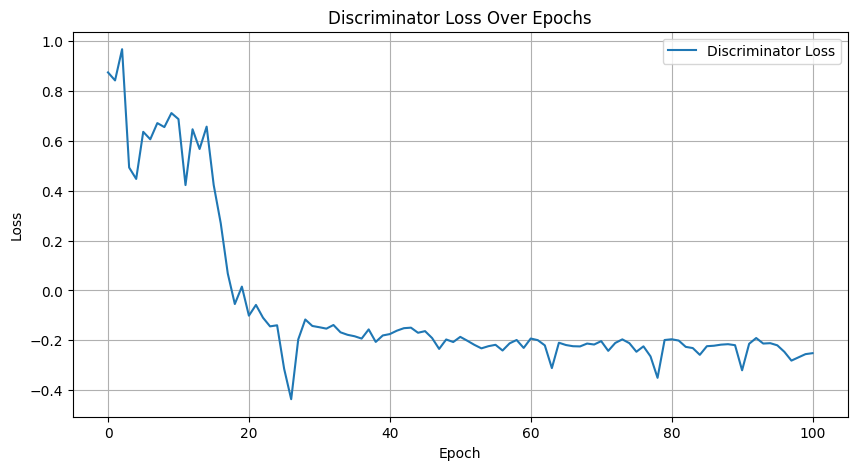

In [27]:
import matplotlib.pyplot as plt
# 绘制判别器损失图
plt.figure(figsize=(10, 5))
plt.plot(d_loss, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('d_loss.png')  # 保存图像为PNG文件
plt.show()

In [28]:
print("g_loss")
print(g_loss)

g_loss
[-0.5179882050340202, -0.6306524452155833, -0.7423364353616538, -0.425646382757384, -0.4381374604683284, -0.5460659065536614, -0.5274082266715245, -0.5199824252730495, -0.4877565524755856, -0.5239889355677261, -0.5066140181999569, -0.44844487746062817, -0.5095315518100095, -0.46461764192409655, -0.48349138887744075, -0.46357560532010406, -0.436885437558413, -0.39787584625091954, -0.36360973916933226, -0.427080974265436, -0.3530983089854937, -0.37111994154395583, -0.33593877467787914, -0.28726253716519956, -0.3086520424849695, -0.2729283500587028, -0.20522117878854312, -0.3217632181313866, -0.3267906635044602, -0.306466445960275, -0.29916601131522164, -0.295990928919819, -0.29158825496975466, -0.282329634582396, -0.2693522467653762, -0.2683828023814781, -0.2657186130513702, -0.27044374363690593, -0.29622007437669196, -0.2686262377205824, -0.2749093808111917, -0.28056710348400593, -0.2817206265608262, -0.276716638568416, -0.26879961503105587, -0.2665634423182477, -0.25415312434973

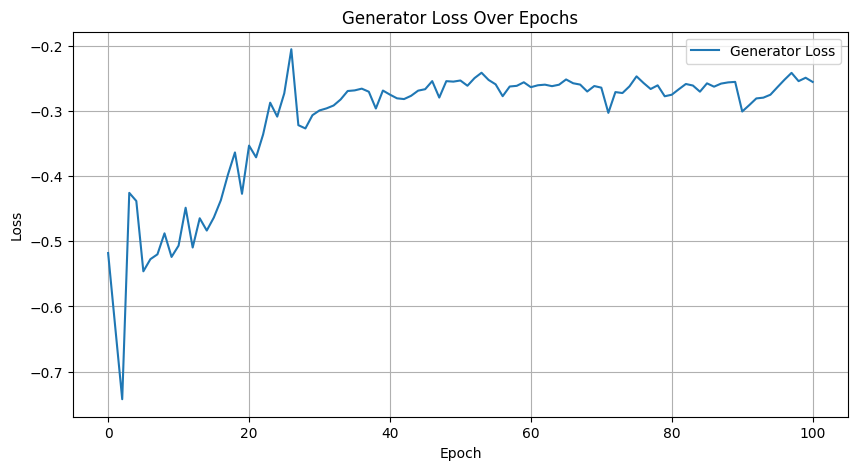

In [29]:
# 绘制生成器损失图
plt.figure(figsize=(10, 5))
plt.plot(g_loss, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('g_loss.png')  # 保存图像为PNG文件
plt.show()

In [30]:
final_gen_flows

array([ 0.01997221,  0.06699828,  0.00283602, -0.05806252,  0.04347916,
       -0.02324454,  0.02718539,  0.01399438,  0.05907797,  0.03341515,
        0.08254275, -0.01265932, -0.01218865,  0.00192298, -0.01243437,
       -0.05468871,  0.2908921 ,  0.23047997,  0.0038649 , -0.00895839,
       -0.03491408, -0.00357144, -0.05667084,  0.00518828, -0.0130722 ,
        0.01664589, -0.01291392, -0.0161425 , -0.01316135,  0.02689124,
        0.03876893, -0.04181667,  0.00974203, -0.02364577,  0.03298815,
        0.02373328,  0.03064307,  0.0164571 ,  0.2249348 ,  0.01175824,
        0.10510807,  0.06500302,  0.11213227,  0.02134855,  0.01022015,
       -0.01150723,  0.01406121, -0.00191702,  0.02467497,  0.00255209,
        0.02640832, -0.00263437, -0.05137888,  0.014251  ,  0.0590406 ,
        0.0787857 , -0.02004316,  0.00210326, -0.02525679, -0.01536237,
       -0.00710959, -0.01431854,  0.02153617, -0.00731923,  0.02218982,
       -0.01247789, -0.00773112, -0.0104423 ,  0.04078431,  0.01

In [31]:
gen_sample = final_gen_flows*(max_values - min_values) + mean_values
print("gen_sample")
print([float("{:.3f}".format(num)) for num in list(gen_sample)])

gen_sample
[2066.967, 37194.618, 17.045, -3886059.624, 4361.234, -2.509, 7740.172, 150.218, 1465.014, 1426.98, 1499.512, -10.617, -13.028, 0.162, -9.508, -31.33, 3009697653.834, 2010219.441, 84231.485, -88311.604, -1629945.647, -77625.782, -3792942.19, 113036.196, -165373.122, 778039.707, -280917.947, -1080166.372, -137640.936, 487375.416, 1217010.392, -3.93, 0.01, 0.0, 0.0, 0.0, 7635252773.193, 22.024, 1999125.606, 11761.74, 1532.511, 1473.76, 1543.068, 17.131, 6556.966, 0.0, 0.014, -0.002, 0.0, 0.003, 0.027, -0.003, 0.0, 0.057, 2196.617, 1493.982, -15.335, 416758117.413, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2229.171, 759.435, -0.833, -111.793, 2674.901, 293.179, 4.087, 80796890.193, -1542.908, 0.0, -757.603, 70.467, -219887.866, 0.0, 796278.097, -863646.294, 0.974]


In [32]:
# 将 NumPy 数组转换为 DataFrame
gen_sample_df = pd.DataFrame([gen_sample], columns=columns)
gen_sample_df

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
0,2066.967364,37194.618493,17.04486,-3.886060e+06,4361.234348,-2.50861,7740.172107,150.217503,1465.014361,1426.980096,...,8.079689e+07,-1542.908251,0.0,-757.602983,70.467488,-219887.866318,0.0,796278.097037,-863646.29446,0.973714


In [33]:
# 将指定列转换为 int64 类型
gen_sample_df.iloc[:, int_columns_indices] = \
    gen_sample_df.iloc[:, int_columns_indices].astype(np.int64, errors='ignore')

In [34]:
gen_sample_df

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
0,2066.0,37194.0,17.0,-3886059.0,4361.0,-2.0,7740.172107,150.217503,1465.014361,1426.980096,...,80796890.0,-1542.908251,0.0,-757.602983,70.467488,-219887.866318,0.0,796278.097037,-863646.29446,0.0
